In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import torch

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.visualization import GameVisualizer, GameReplayer
from src.models import AE_Trainer, AELSTM
from src.datahandlers import PacmanDataset, PacmanDataReader, Trajectory
from aeon.clustering.deep_learning import AEDRNNClusterer, AEDCNNClusterer, AEResNetClusterer
from aeon.clustering import DummyClusterer



In [ ]:

reader = PacmanDataReader(data_folder="../data")
raw_data, sequence_list, traj_list, gif_path_list = reader.slice_seq_of_each_level(
    start_step=0, end_step=100, make_gif=True)

padded_sequence_list = reader.padding_sequences(sequence_list=sequence_list)


Aeon includes several deep-clustering models and the whole (UCR time series classification archive) benchmark datasets. One of these datasets is a "trajectory" dataset of PenDigits, where there are the 10 digits as classes (and labels), but the writting style might differ (more than 1 way to make the same 5). The code for Pendigits is commented out, and the Pacman data is used instead. However, it is useful to perform sanity checks of different elements of the higher-level pipeline.

As noted by inspecting the PenDigits dataset, and other UCR sets, aeon models expect an input of [n_samples, features, seq_length]. Keras, and Torch use the most standard [n_samples, seq_length, features]. So, if inputting directly to an aeon classs (as below) remember to transpose the data. However, if accessing the underlying keras models directly, as when extracting embeddings, transposing will not be necessary. 

In [4]:
### KERAS MODELS
# from aeon.datasets import load_classification

# UCR_data = load_classification("PenDigits")

keras_autoencoder = AEDRNNClusterer(
            estimator= DummyClusterer(),
            verbose = True,
            n_epochs= 5,
            validation_split=0.15,
            latent_space_dim = 256,
            save_best_model=True,
            best_file_name="test",
            save_last_model=True,
            last_file_name="test",
            )

# keras_autoencoder.fit(padded_sequence_list.transpose(0,2,1))
# # keras_autoencoder.fit(UCR_data[0])



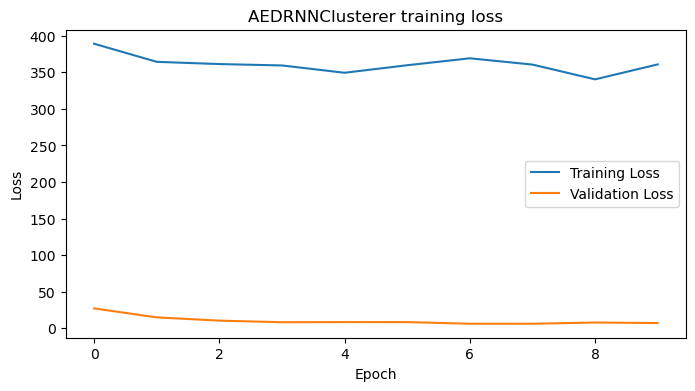

In [14]:
keras_autoencoder.plot_loss_keras()

As noted in the plot loss, the dilated models (both DRNN and DCNN) have a validation loss always superior to the training loss. It is still not clear to me why does this happen, as there is no dropout that would increase training loss. So my guess is that is a byproduct of the dilation? I haven't digged enough into it because, at the end, if the validation loss is low, then it works fine.


While the aeon module provides the whole pipeline to train, embedd, and cluster, I want to have more direct control over the embedings for the purpose of reducing and visualizing the latent space. With this goal in mind, we extract them manually from the .model_.layer[1] which is always the encoder module. If our data is already in [n, seq_length, feats] we remember not to transpose.


c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(938, 100, 2))
  warnings.warn(msg)


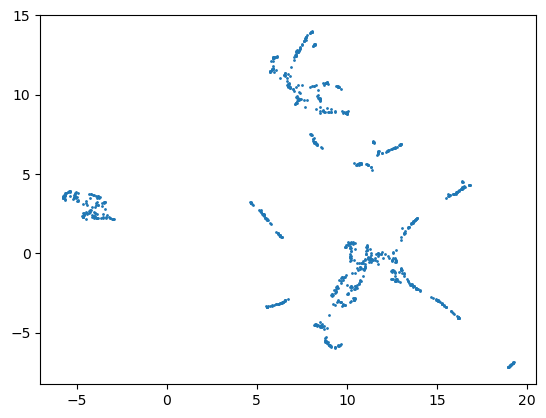

In [5]:
## Load model trained in the high performance computing environments
keras_autoencoder.load_model("../hpc/trained_models/first_5_seconds/f2/AEDRNNClusterer_h256_e500_last.keras", estimator=None)

embedd = keras_autoencoder.model_.layers[1](padded_sequence_list)

from umap import UMAP

reduced = UMAP().fit_transform(embedd)

import matplotlib.pyplot as plt

plt.scatter(reduced[:,0], reduced[:,1], s=1)

By plotting the latent space we can assess the distribution of the different clusters and data-points. While the axes do not represent anything practically usefull, we can still reliably assess visually wether we have "good" or "bad" clusters. In this case, we see that data points are not uniformaly distributed across the latent space (as it can happen in other slices of gamestates, more of that in later notebooks). As such, we say that we found some structure to the data. Whether we can make sense of it is another story.

# PyTorch models

Before we continue with the clustering and visualization steps, we show the torch models. In this case, we implemented a simple LSTM auto-encoder. This model is simpler than the keras AutoEncoders' architechture, but it does not lack much in performance, it can be trained quite quickly, and serves as a nice Neural Networks' baseline. If transformer are user, they will probably follow this same logic.

First, we need to ensure our data can be feeded as a `torch.Tensor` dataclass, which is the backbone of torch library. A custom class is defined, which also generates a masking variable, which will later mask the error loss to avoid inconsistencies with varying-length sequences.

In [7]:

data_tensor = PacmanDataset(padded_sequence_list)
data_tensor.gamestates.shape

torch.Size([938, 100, 2])

Different to Keras, in torch is usual to implemen a trainer class, or the training algorithm. In our case, the trainer uses masked reconstruction loss (if the datatensor includes a "mask" variable, which it does) and a loss_plot function

In [12]:
trainer = AE_Trainer(max_epochs=10, 
                     batch_size=32, 
                     validation_split=0.3)

model = AELSTM(input_size=data_tensor[0]["data"].shape[1], hidden_size=256)

# ### LOAD
# model.load_state_dict(torch.load('../hpc/trained_models/first_5_seconds/f2/AELSTM_h256_e1000_best.pth', map_location=torch.device("cpu")))
# model.eval()  # Set to evaluation mode if not training

### TRAIN
trainer.fit(model, data_tensor)

Epoch 1: Train loss=89.86769594464984, Val loss=67.45682822333441
Epoch 2: Train loss=52.51892598470052, Val loss=45.27193620469835
Epoch 3: Train loss=42.84135355268206, Val loss=37.68383471171061
Epoch 4: Train loss=33.64768010094052, Val loss=30.98677550421821
Epoch 5: Train loss=28.889013472057524, Val loss=25.894869062635635
Epoch 6: Train loss=22.87229501633417, Val loss=21.61493174235026
Epoch 7: Train loss=19.706880978175572, Val loss=18.430187649197048
Epoch 8: Train loss=16.591363271077473, Val loss=16.66612720489502
Epoch 9: Train loss=14.895007996332078, Val loss=14.51283688015408
Epoch 10: Train loss=13.426213536943708, Val loss=12.891114976671007


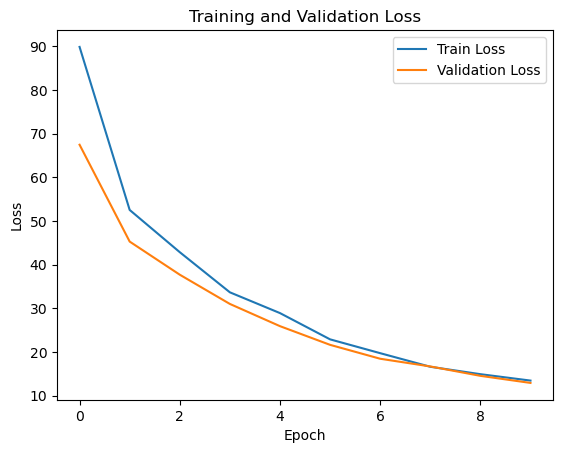

In [13]:
trainer.plot_loss()

# Whole Pipeline

Following, is the whole pipeline, from data-slicing - embedding - reducing - clustering. We use both HDBSCAN and KMeans clustering algorithms. More detailed reflection will be in the `PatternExtraction.ipynb` where we will compare the effects of variations in the pipeline, which is all refactored in the `PatternExtraction` class. 

Besides the first 5 seconds, which we have been using so far, we include the last 5 seconds. Note the difference in the resulting latent space, which is hypothesized to be due to the low variability of the first 5 seconds in terms of ghost positions and fixed starting position, opposed to the highly variable end-state of each level.

embedding for LSTM trained on first_5_seconds (2 features)
Processed all batches in 2.141880750656128 seconds
embedding for LSTM trained on last_5_seconds (2 features)
Processed all batches in 1.998558759689331 seconds


c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Localadmin_pabflore\miniconda3\envs\pacman_encoder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


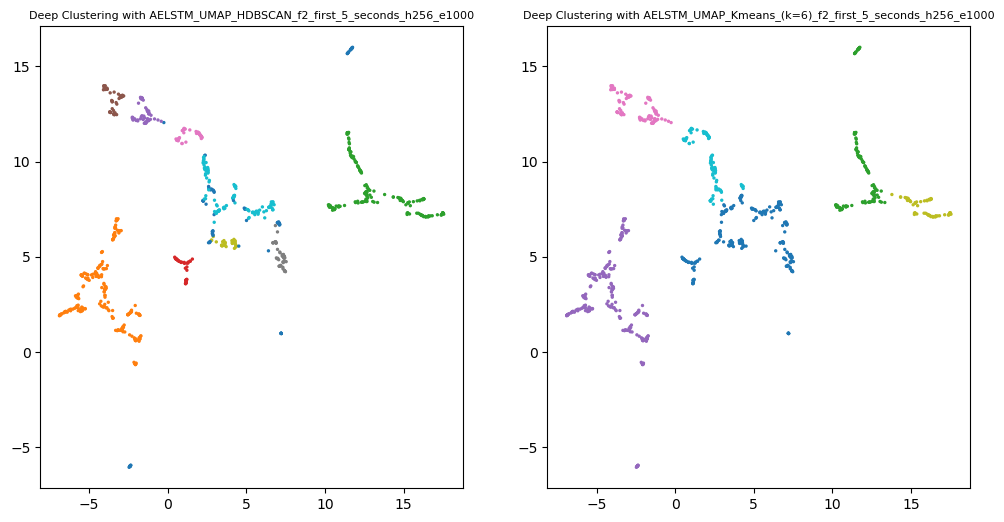

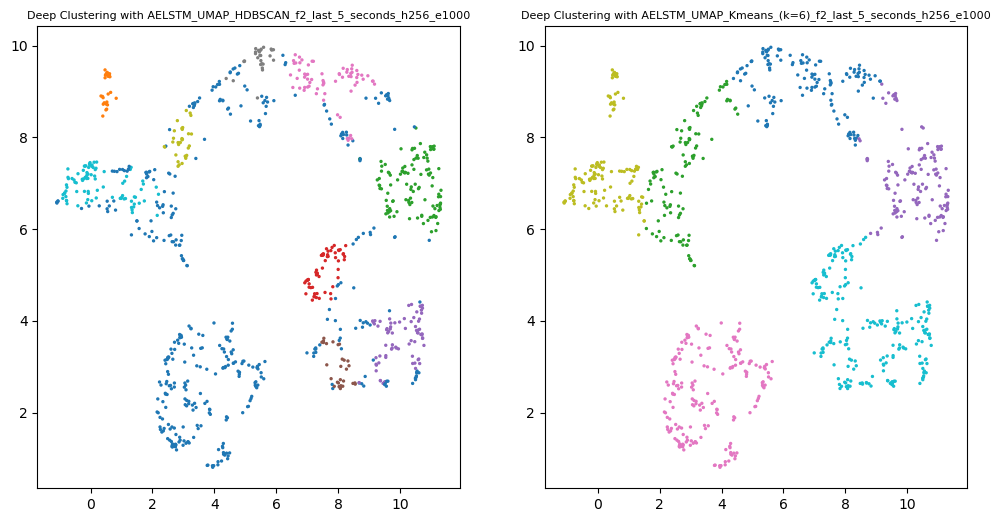

In [3]:
### Whole slicing, loading-model, embedding, reducing, clustering, plotting

sequence_types = [
    "first_5_seconds",
     "last_5_seconds",
    #  "whole_level"
     ]

FEATURES_COLUMNS= [
    # "score", 
    # "lives", 
    # "pacman_attack",
    "Pacman_X",
    "Pacman_Y",
    # "Ghost1_X",
    # "Ghost1_Y",            
    # "Ghost2_X",
    # "Ghost2_Y",
    # "Ghost3_X",
    # "Ghost3_Y",
    # "Ghost4_X",
    # "Ghost4_Y",
    ]
N_FEATURES = len(FEATURES_COLUMNS) # INPUT_SIZE. 

reader = PacmanDataReader(data_folder="../data")

sequences_data = []

for seq_type in sequence_types:
    if seq_type == "first_5_seconds":
        raw_data, sequence_list, traj_list, gif_path_list = reader.slice_seq_of_each_level(start_step=0, end_step=100, FEATURES=FEATURES_COLUMNS, make_gif="True")
    elif seq_type == "whole_level":
        raw_data, sequence_list, traj_list, gif_path_list = reader.slice_seq_of_each_level(start_step=0, end_step=-1, FEATURES=FEATURES_COLUMNS, make_gif="False")
    elif seq_type == "last_5_seconds":
        raw_data, sequence_list, traj_list, gif_path_list = reader.slice_seq_of_each_level(start_step=-100, end_step=-1, FEATURES=FEATURES_COLUMNS, make_gif="True") 

    X_padded = reader.padding_sequences(sequence_list=sequence_list)
    sequences_data.append(PacmanDataset(X_padded))
    level_ids = [traj.metadata["level_id"] for traj in traj_list]

### LOADING MODELS
HIDDEN_SIZE = 256
EPOCHS = 1000
models = []

for seq_type in sequence_types:
    model = AELSTM(input_size = N_FEATURES, hidden_size=HIDDEN_SIZE)
    model.load_state_dict(torch.load(
        os.path.join(
            "..",
            "hpc",
            "trained_models",
            seq_type,
            "f" + str(N_FEATURES),
            f"AELSTM_h{HIDDEN_SIZE}_e{EPOCHS}_best.pth"
        ),
        map_location=torch.device('cpu')))
    model.name = (f"LSTM trained on {seq_type} ({N_FEATURES} features)")
    models.append(model)


from umap import UMAP
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt
import time

### EMBEDDING AND REDUCING

# Process in batches to avoid memory issues
BATCH_SIZE = 32  # Adjust based on your available memory

reduced_embeddings = [] # : [np.ndarray] empty lists for final results, each item would be a [n, 2] array for each model.

## Embed, and reduce the data for each model
for idx, model in enumerate(models):
    print(f"embedding for {model.name}")
    all_embeddings = []
    ti = time.time()
    model.eval()
    with torch.no_grad():  # Important: disable gradients for inference
        for i in range(0, len(sequences_data[idx]), BATCH_SIZE):
            batch_data = sequences_data[idx][i:i+BATCH_SIZE]["data"]
            
            # Get embeddings for this batch
            _, batch_embeddings = model.forward(batch_data, return_encoding=True)
            all_embeddings.append(batch_embeddings.cpu())  # Move to CPU to save GPU memory
            # if i%5 == 0:
            #     print(f"Processed batch {i//BATCH_SIZE + 1}/{(len(data_tensor)-1)//BATCH_SIZE + 1}")

    tf = time.time()
    print(f"Processed all batches in {tf - ti} seconds")
    # Concatenate all embeddings
    embeddings = torch.cat(all_embeddings, dim=0)
    reducer = UMAP()    
    embeddings_2D = reducer.fit_transform(embeddings.detach().numpy())

    reduced_embeddings.append(embeddings_2D)


## CLUSTERING

N_CLUSTERS = 6 ## for k-means

clusterers = {}
clusterers["HDBSCAN"] = HDBSCAN(min_cluster_size=20)
clusterers[f"Kmeans_(k={N_CLUSTERS})"] = KMeans(n_clusters=6)

for idx, model in enumerate(models):
    labels = {}
    for name, clusterer in clusterers.items():
        labels[name] = clusterer.fit_predict(reduced_embeddings[idx])

    ## plot

    fig, axs = plt.subplots( 1, len(labels.values()), figsize=(6 * len(labels.values()),6))

    for i, (clusterer_name, predictions) in enumerate(labels.items()):
        axs[i].scatter(reduced_embeddings[idx][:,0], reduced_embeddings[idx][:,1], 
                       s=2, 
                       cmap="tab10", 
                       c=predictions)
        axs[i].set_title(f"Deep Clustering with {model.__class__.__name__}_UMAP_{clusterer_name}_f{N_FEATURES}_{sequence_types[idx]}_h{HIDDEN_SIZE}_e{EPOCHS}", size=8)
    
    # fig.savefig(fname=f"results/DeepClusteringResults_plot_{model.__class__.__name__}_f{N_FEATURES}_{sequence_types[idx]}_h{HIDDEN_SIZE}_e{EPOCHS}")

    # fig.savefig(fname="results/DeepClusteringResults_plot_Pacman_WholeSequence_LSTM")

## Augmented Visualization

For enhanced interpretability of the clusters, we enhanced the visualization of the latent space by rendering .gif animations of the sequences. This is done in the data slicing step, in `reader.slice_seq_of_each_level(make_gif=True)`.

This follow the visualization method of Rasajski, et al., (2024).

It uses Bokeh library. gif paths are feeded into the `ColumnDataSource()` class and a custom html format for the hoovertool is given.


In [5]:
#### Interactive Vis (w .gif paths) -> ClusterVis (?)

from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import (
    ColorBar,
    LinearColorMapper,
    CategoricalColorMapper,
    ColumnDataSource,
)

from bokeh.palettes import Viridis256

output_file("last_5_seconds_plot.html")

_, _, _, gif_path_list = reader.slice_seq_of_each_level(start_step=-100, end_step=-1, FEATURES=FEATURES_COLUMNS, make_gif="True") 

# Create the data dict to feed as ColumnDataSource (Bokeh data structure)
cluster_str = [str(c) for c in labels["HDBSCAN"]] # Ensure cluster is string for color mapping
data = dict(
        x=reduced_embeddings[1][:, 0],
        y=reduced_embeddings[1][:, 1],
        cluster=cluster_str,
        level_id=level_ids,
        gif_path= gif_path_list,
    )

for key in traj_list[0].metadata.keys():
    data[str(key)] = [traj.metadata[key] for traj in traj_list]

source = ColumnDataSource(
    data=data
)

MEDIUM = {
    "fig_size" : (1080, 720),
    "tooltips_size" : (200,200),
} ## Good for notebook / smaller display
LARGE = {
    "fig_size" : (1920, 980),
    "tooltips_size" : (400,400),
} ## Good for the big display

SIZE = LARGE


TOOLTIPS = f"""
    <div>
        <div>
            <img
                src="@gif_path" height="{SIZE["tooltips_size"][1]}" alt="@gif_path" width="{SIZE["tooltips_size"][0]}"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""


p = figure(
    title="UMAP-HDBSCAN Embeddings",
    # tooltips=[("level_id", "@level_id"), ("cluster", "@cluster")],
    tooltips=TOOLTIPS,
    width= SIZE["fig_size"][0],
    height= SIZE["fig_size"][1]
)

# Create color mapper for clusters
unique_labels = np.sort(np.unique(labels["HDBSCAN"]))
unique_labels_str = [str(label) for label in unique_labels]
n_clusters = len(unique_labels)

# If we have noise points (-1), we need a special color for them
if -1 in unique_labels:
    step = max(1, 256 // (n_clusters - 1)) if (n_clusters - 1) > 0 else 1
    colors = ["gray"] + list(Viridis256[::step][: n_clusters - 1])
else:
    step = max(1, 256 // n_clusters)
    colors = list(Viridis256[::step][:n_clusters])

color_mapper = CategoricalColorMapper(factors=unique_labels_str, palette=colors)

# Add scatter plot with color mapping
scatter = p.scatter(
    x="x",
    y="y",
    source=source,
    color={"field": "cluster", "transform": color_mapper},
    legend_field="cluster",
)

# Fix legend: Bokeh auto-creates legend items for legend_field
p.legend.title = "Clusters"
p.legend.location = "top_right"
p.legend.label_text_font_size = "8pt"

output_notebook()
show(p)

Loading BokehJS ...